In [10]:
import torch
print("PyTorch has version {}".format(torch.__version__))

import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms

PyTorch has version 1.12.1


# Complete the Transfer Learn on KITTI with pytorch
## Prepare the dataset

In [86]:
# https://zhuanlan.zhihu.com/p/103862272
# https://gauenk.github.io/docs/how_faster_rcnn_accepts_various_input_image_sizes.pdf
transform = transforms.Compose([
    transforms.Resize((800, 800)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]) 

# https://github.com/pytorch/vision/issues/215
def target_transform(target):
    pass

# https://github.com/xiaowei305/perception/blob/9965418a43cc04dc8ca78e3b1324704501c257f0/ch2/densebox/train.py
import numpy as np
def kitti_collate_fn(batch_data):
    class_names = ['Car', 'Truck', 'Cyclist', 'Tram', 'Person_sitting', 'Misc', 'Van', 'Pedestrian']

    unit_image, unit_target = [], []
    for img, target in batch_data:
        c, h, w = img.shape
        for x in target:
            if x['type'] != "DontCare":
                boxes = np.array([x["bbox"]])
                classes = np.array([class_names.index(x['type'])])
                
        #boxes = np.array([x["bbox"] for x in target if x['type'] != "DontCare"])
        #classes = np.array([class_names.index(x['type']) for x in target if x['type'] != "DontCare"])
        #if len(boxes) <= max_boxes:
        #    boxes = np.pad(boxes, ((0, max_boxes - len(boxes)), (0, 0))) # https://blog.csdn.net/Tan_HandSome/article/details/80296827
        #    classes = np.pad(classes, (0, max_boxes - len(classes)))
        #else:
        #    boxes = boxes[:11]
        #    classes = classes[:11]
            
        #boxes /= np.array([w, h, w, h])
        boxes = torch.from_numpy(np.stack(boxes, axis=0))
        #//print(boxes)
        classes = torch.from_numpy(np.stack(classes, axis=0))

        target_ = {}
        target_['boxes'] = boxes
        target_['labels'] = classes
         
        unit_image += [img]  
        unit_target.append(target_) 
    return unit_image, unit_target

# https://pytorch.org/vision/stable/generated/torchvision.datasets.Kitti.html#torchvision.datasets.Kitti
# https://pytorch.org/vision/master/_modules/torchvision/datasets/kitti.html
train_dataset = torchvision.datasets.Kitti(
    root='./kitti-dataset',
    train=True, download=True, transform=transform, #target_transform=target_transform
)
trainloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=8, shuffle=True, collate_fn=kitti_collate_fn)

for batch in trainloader:
    #print(batch)
    pass

In [87]:
print(train_dataset)
print(test_dataset)

Dataset Kitti
    Number of datapoints: 3201
    Root location: ./kitti-dataset
    StandardTransform
Transform: Compose(
               Resize(size=(800, 800), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Dataset Kitti
    Number of datapoints: 100
    Root location: ./kitti-dataset-for-valid
    StandardTransform
Transform: Compose(
               Resize(size=(800, 800), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [82]:
test_dataset = torchvision.datasets.Kitti(
    root='./kitti-dataset-for-valid',
    train=True, download=True, transform=transform
)
testloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=8, shuffle=True, collate_fn=kitti_collate_fn)

# testloader train=Flase, just not fetch labels
for batch in testloader:
    pass

## Prepare the model

In [105]:
# demo in pytorch document #!DONOT RUN THIS CELL
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
images, boxes = torch.rand(4, 3, 600, 1200), torch.rand(4, 11, 4)
labels = torch.randint(1, 91, (4, 11)) # from 1 to 91, each box in each png match one label
images = list(image for image in images)
targets = []
for i in range(len(images)):
    d = {}
    d['boxes'] = boxes[i]
    d['labels'] = labels[i]
    print(d)
    break
    targets.append(d)

#len(images)  # 4
#len(targets) # 4

#output = model(images, targets)

/Applications/anaconda3/envs/tflearn/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/Applications/anaconda3/envs/tflearn/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


{'boxes': tensor([[0.5953, 0.4388, 0.2016, 0.0624],
        [0.5888, 0.5681, 0.9583, 0.9076],
        [0.9424, 0.0798, 0.0354, 0.2861],
        [0.4587, 0.8284, 0.8997, 0.6154],
        [0.7531, 0.8675, 0.5503, 0.1531],
        [0.5151, 0.5926, 0.8113, 0.1086],
        [0.0847, 0.2823, 0.6391, 0.6936],
        [0.1617, 0.8279, 0.8987, 0.7467],
        [0.0821, 0.2013, 0.0910, 0.4601],
        [0.4938, 0.7785, 0.1791, 0.4087],
        [0.6775, 0.8924, 0.9092, 0.0739]]), 'labels': tensor([76, 55, 68, 51, 63, 37, 35, 61, 42, 55, 68])}


In [62]:
# http://pytorch.org/vision/master/models/faster_rcnn.html
FasterRCNN = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
'''
FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, eps=0.0)
          )
        )
        (1): Bottleneck(
          (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(inplace=True)
        )
        (2): Bottleneck(
          (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(inplace=True)
        )
      )
      (layer2): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(128, eps=0.0)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(128, eps=0.0)
          (conv3): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(512, eps=0.0)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
            (1): FrozenBatchNorm2d(512, eps=0.0)
          )
        )
        (1): Bottleneck(
          (conv1): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(128, eps=0.0)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(128, eps=0.0)
          (conv3): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(512, eps=0.0)
          (relu): ReLU(inplace=True)
        )
        (2): Bottleneck(
          (conv1): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(128, eps=0.0)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(128, eps=0.0)
          (conv3): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(512, eps=0.0)
          (relu): ReLU(inplace=True)
        )
        (3): Bottleneck(
          (conv1): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(128, eps=0.0)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(128, eps=0.0)
          (conv3): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(512, eps=0.0)
          (relu): ReLU(inplace=True)
        )
      )
      (layer3): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(256, eps=0.0)
          (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(256, eps=0.0)
          (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(1024, eps=0.0)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(512, 1024, kernel_size=(1, 1), stride=(2, 2), bias=False)
            (1): FrozenBatchNorm2d(1024, eps=0.0)
          )
        )
        (1): Bottleneck(
          (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(256, eps=0.0)
          (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(256, eps=0.0)
          (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(1024, eps=0.0)
          (relu): ReLU(inplace=True)
        )
        (2): Bottleneck(
          (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(256, eps=0.0)
          (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(256, eps=0.0)
          (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(1024, eps=0.0)
          (relu): ReLU(inplace=True)
        )
        (3): Bottleneck(
          (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(256, eps=0.0)
          (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(256, eps=0.0)
          (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(1024, eps=0.0)
          (relu): ReLU(inplace=True)
        )
        (4): Bottleneck(
          (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(256, eps=0.0)
          (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(256, eps=0.0)
          (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(1024, eps=0.0)
          (relu): ReLU(inplace=True)
        )
        (5): Bottleneck(
          (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(256, eps=0.0)
          (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(256, eps=0.0)
          (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(1024, eps=0.0)
          (relu): ReLU(inplace=True)
        )
      )
      (layer4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(512, eps=0.0)
          (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(512, eps=0.0)
          (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(2048, eps=0.0)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False)
            (1): FrozenBatchNorm2d(2048, eps=0.0)
          )
        )
        (1): Bottleneck(
          (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(512, eps=0.0)
          (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(512, eps=0.0)
          (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(2048, eps=0.0)
          (relu): ReLU(inplace=True)
        )
        (2): Bottleneck(
          (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(512, eps=0.0)
          (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(512, eps=0.0)
          (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(2048, eps=0.0)
          (relu): ReLU(inplace=True)
        )
      )
    )
    (fpn): FeaturePyramidNetwork(
      (inner_blocks): ModuleList(
        (0): Conv2dNormActivation(
          (0): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
        )
        (3): Conv2dNormActivation(
          (0): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
        )
      )
      (layer_blocks): ModuleList(
        (0): Conv2dNormActivation(
          (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (3): Conv2dNormActivation(
          (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
      (extra_blocks): LastLevelMaxPool()
    )
  )
  (rpn): RegionProposalNetwork(
    (anchor_generator): AnchorGenerator()
    (head): RPNHead(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU(inplace=True)
        )
      )
      (cls_logits): Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1))
      (bbox_pred): Conv2d(256, 12, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (roi_heads): RoIHeads(
    (box_roi_pool): MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(7, 7), sampling_ratio=2)
    (box_head): TwoMLPHead(
      (fc6): Linear(in_features=12544, out_features=1024, bias=True)
      (fc7): Linear(in_features=1024, out_features=1024, bias=True)
    )
    (box_predictor): FastRCNNPredictor(
      (cls_score): Linear(in_features=1024, out_features=91, bias=True)
      (bbox_pred): Linear(in_features=1024, out_features=364, bias=True)
    )
  )
)
'''

/Applications/anaconda3/envs/tflearn/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/Applications/anaconda3/envs/tflearn/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


"\nFasterRCNN(\n  (transform): GeneralizedRCNNTransform(\n      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])\n      Resize(min_size=(800,), max_size=1333, mode='bilinear')\n  )\n  (backbone): BackboneWithFPN(\n    (body): IntermediateLayerGetter(\n      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)\n      (bn1): FrozenBatchNorm2d(64, eps=0.0)\n      (relu): ReLU(inplace=True)\n      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)\n      (layer1): Sequential(\n        (0): Bottleneck(\n          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)\n          (bn1): FrozenBatchNorm2d(64, eps=0.0)\n          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)\n          (bn2): FrozenBatchNorm2d(64, eps=0.0)\n          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)\n          (bn3): FrozenBatchNorm2d(256, eps=0.0)\n 

In [63]:
# model pre-trained
in_features = FasterRCNN.roi_heads.box_predictor.cls_score.in_features
FasterRCNN.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(
    in_features, num_classes=8)

In [18]:
for images, labels in iter(trainloader):
    #print(images)
    print(len(images))
    #print(labels)
    print(len(labels))
    break

8
8


# Train and Evaluate

- https://debuggercafe.com/custom-object-detection-using-pytorch-faster-rcnn/
- https://debuggercafe.com/a-simple-pipeline-to-train-pytorch-faster-rcnn-object-detection-model/
- https://github.com/haochen23/Faster-RCNN-fine-tune-PyTorch

In [64]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0
        
    def send(self, value):
        self.current_total += value
        self.iterations += 1
    
    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations
    
    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [92]:
NUM_EPOCHS = 500
best_accuracy = 0.0
DEVICE = torch.device('cpu')
        
        
# Freeze 
FasterRCNN.eval()
for name, param in FasterRCNN.named_parameters():
    # If requires gradient parameters
    if param.requires_grad:
        if name not in ["roi_heads.box_predictor.cls_score.weight", 
            "roi_heads.box_predictor.cls_score.bias",
            #"roi_heads.box_predictor.bbox_pred.bias",
            #"roi_heads.box_predictor.bbox_pred.weight",
            
            #"roi_heads.box_head.fc7.bias",
            #"roi_heads.box_head.fc7.weight",
            #"roi_heads.box_head.fc6.bias",
            #"roi_heads.box_head.fc6.weight",
            #"rpn.head.bbox_pred.bias",
            #"rpn.head.bbox_pred.weight",
            #"rpn.head.cls_logits.bias",
            #"rpn.head.cls_logits.weight",
            #"rpn.head.conv.0.0.bias",
            #"rpn.head.conv.0.0.weight" 
        ]:
            param.requires_grad = False
        if param.requires_grad:
            # Name and value of the parameter
            print("Name: ",name,"\nBool: ",param.requires_grad,"\n")
            
params = [p for p in FasterRCNN.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

FasterRCNN.load_state_dict(torch.load('./kitti-model/model1.pth'))

train_itr = 1
val_itr = 1
train_loss_list, val_loss_list = [], [] 
train_loss_hist = Averager()
val_loss_hist = Averager()

min_loss = 0.15

from tqdm.auto import tqdm
  
for epoch in range(NUM_EPOCHS):
    
    print(f"\nEPOCH {epoch+1} of {NUM_EPOCHS}:")
    train_loss_hist.reset()
    val_loss_hist.reset()
    
    
    FasterRCNN.train()
    print("#### TRAINING ####")
    prog_bar = tqdm(trainloader, total=len(trainloader))
    for i, data in enumerate(prog_bar):
        
        optimizer.zero_grad()
        images, targets = data
        #//print(images, targets)
        
        loss_dict = FasterRCNN(images, targets)
        #{'loss_classifier': tensor(3.0745, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0106, grad_fn=<DivBackward0>), 'loss_objectness': tensor(2.0545, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(1.3918, dtype=torch.float64, grad_fn=<DivBackward0>)}
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        train_loss_list.append(loss_value)
        train_loss_hist.send(loss_value)
        
        losses.backward()
        optimizer.step()
        train_itr += 1
    print("#### TRAIN END ####")
    
    lr_scheduler.step()
    
    print("#### VALIDATING ####")
    prog_bar = tqdm(testloader, total=len(testloader))
    for i, data in enumerate(prog_bar):
        
        images, targets = data 
               
        with torch.no_grad():
            loss_dict = FasterRCNN(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        val_loss_list.append(loss_value)
        val_loss_hist.send(loss_value)
        
        val_itr += 1
    print("#### VALID END ####")
    
    print(f"EPOCH #{epoch} TRAIN LOSS: {train_loss_hist.value:.3f} and VALID LOSS: {val_loss_hist.value:.3f}")   
    if train_loss_hist.value < min_loss:
        min_loss = train_loss_hist.value
        torch.save(FasterRCNN.state_dict(), f"{'kitti-model'}/model_best.pth")  
              
    if (epoch+1) % 4 == 0: # save model after every n epochs
        torch.save(FasterRCNN.state_dict(), f"{'kitti-model'}/model{epoch+1}.pth")
        print('SAVING MODEL COMPLETE...\n')


Name:  roi_heads.box_predictor.cls_score.weight 
Bool:  True 

Name:  roi_heads.box_predictor.cls_score.bias 
Bool:  True 


EPOCH 1 of 500:
#### TRAINING ####


  0%|          | 0/401 [00:00<?, ?it/s]

#### TRAIN END ####
#### VALIDATING ####


  0%|          | 0/13 [00:00<?, ?it/s]

#### VALID END ####
EPOCH #0 TRAIN LOSS: 1.132 and VALID LOSS: 0.851

EPOCH 2 of 500:
#### TRAINING ####


  0%|          | 0/401 [00:00<?, ?it/s]

#### TRAIN END ####
#### VALIDATING ####


  0%|          | 0/13 [00:00<?, ?it/s]

#### VALID END ####
EPOCH #1 TRAIN LOSS: 1.132 and VALID LOSS: 0.846

EPOCH 3 of 500:
#### TRAINING ####


  0%|          | 0/401 [00:00<?, ?it/s]

#### TRAIN END ####
#### VALIDATING ####


  0%|          | 0/13 [00:00<?, ?it/s]

#### VALID END ####
EPOCH #2 TRAIN LOSS: 1.128 and VALID LOSS: 0.851

EPOCH 4 of 500:
#### TRAINING ####


  0%|          | 0/401 [00:00<?, ?it/s]

#### TRAIN END ####
#### VALIDATING ####


  0%|          | 0/13 [00:00<?, ?it/s]

#### VALID END ####
EPOCH #3 TRAIN LOSS: 1.134 and VALID LOSS: 0.852
SAVING MODEL COMPLETE...


EPOCH 5 of 500:
#### TRAINING ####


  0%|          | 0/401 [00:00<?, ?it/s]

#### TRAIN END ####
#### VALIDATING ####


  0%|          | 0/13 [00:00<?, ?it/s]

#### VALID END ####
EPOCH #4 TRAIN LOSS: 1.129 and VALID LOSS: 0.843

EPOCH 6 of 500:
#### TRAINING ####


  0%|          | 0/401 [00:00<?, ?it/s]

#### TRAIN END ####
#### VALIDATING ####


  0%|          | 0/13 [00:00<?, ?it/s]

#### VALID END ####
EPOCH #5 TRAIN LOSS: 1.137 and VALID LOSS: 0.839

EPOCH 7 of 500:
#### TRAINING ####


  0%|          | 0/401 [00:00<?, ?it/s]

#### TRAIN END ####
#### VALIDATING ####


  0%|          | 0/13 [00:00<?, ?it/s]

#### VALID END ####
EPOCH #6 TRAIN LOSS: 1.135 and VALID LOSS: 0.854

EPOCH 8 of 500:
#### TRAINING ####


  0%|          | 0/401 [00:00<?, ?it/s]

#### TRAIN END ####
#### VALIDATING ####


  0%|          | 0/13 [00:00<?, ?it/s]

#### VALID END ####
EPOCH #7 TRAIN LOSS: 1.131 and VALID LOSS: 0.857
SAVING MODEL COMPLETE...


EPOCH 9 of 500:
#### TRAINING ####


  0%|          | 0/401 [00:00<?, ?it/s]

#### TRAIN END ####
#### VALIDATING ####


  0%|          | 0/13 [00:00<?, ?it/s]

#### VALID END ####
EPOCH #8 TRAIN LOSS: 1.130 and VALID LOSS: 0.870

EPOCH 10 of 500:
#### TRAINING ####


  0%|          | 0/401 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Eval Visualization

freeze cls_score layer:  
|           scale                         | stable loss |
| ----------------------------------------|----------|
| [160 train images,   40 validate images]| loss 1.7 | 
| [400 train images,  100 validate images]| loss 0.9 |
| [3201 train images, 100 validate images]| loss 1.13|


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt 
from PIL import Image
import torchvision.transforms as T
import cv2

# https://haochen23.github.io/2020/04/object-detection-faster-rcnn.html#.Y0VLb8pBxJY

FasterRCNNtest = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = FasterRCNNtest.roi_heads.box_predictor.cls_score.in_features
FasterRCNNtest.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(
    in_features, num_classes=8)

torch.save(FasterRCNNtest.state_dict(), f"{'kitti-model'}/model-origin.pth")
FasterRCNNtest.load_state_dict(torch.load('./kitti-model/model8.pth'))

FasterRCNNtest.eval()

#FasterRCNN.eval()

CLASS_NAMES = ['Car', 'Truck', 'Cyclist', 'Tram', 'Person_sitting', 'Misc', 'Van', 'Pedestrian']


def get_prediction(img_path, confidence):
  """
    parameters:
      - img_path - path of the input image
      - confidence - threshold value for prediction score
  """
  img = Image.open(img_path)
  transform = T.Compose([T.ToTensor()])
  img = transform(img)
  pred = FasterRCNNtest([img]) # FasterRCNNtest
  
  print(pred)
  if pred[0]['scores'].detach().numpy().size == 0:
    return None, None
  pred_class = [CLASS_NAMES[i] for i in list(pred[0]['labels'].numpy())]
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
  pred_score = list(pred[0]['scores'].detach().numpy())
  #//print(pred_score)
  pred_index = []
  for x in pred_score:
    if x > confidence:
      #//print(pred_score.index(x))
      pred_index.append(pred_score.index(x))
      print(pred_index)
  if len(pred_index) == 1:
      print("Only One Object Detected.")
      return [pred_boxes[0]], [pred_class[0]] 
  if len(pred_index) == 0:
      print("No Object Detected.")
      return None, None
    
  pred_t = [pred_score.index(x) for x in pred_score if x>confidence][-1]
  pred_boxes = pred_boxes[:pred_t+1]
  pred_class = pred_class[:pred_t+1]
  return pred_boxes, pred_class


def detect_object(img_path, confidence=0.5, rect_th=2, text_size=0.5, text_th=2):
  """
    parameters:
      - img_path - path of the input image
      - confidence - threshold value for prediction score
      - rect_th - thickness of bounding box
      - text_size - size of the class label text
      - text_th - thichness of the text
  """
  boxes, pred_cls = get_prediction(img_path, confidence)
  if boxes == None and pred_cls == None:
    print("NO Detection")
    return None
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  
  for i in range(len(boxes)):
    aa, bb = boxes[i][0][0], boxes[i][0][1]
    a, b = boxes[i][1][0], boxes[i][1][1]
    cv2.rectangle(img, (int(aa), int(bb)), (int(a), int(b)), 
                  color=(0, 255, 0), thickness=rect_th)
    cv2.putText(img, pred_cls[i], (int(aa), int(bb)), cv2.FONT_HERSHEY_SIMPLEX,
                text_size, (0,255,0),thickness=text_th)
  
  plt.figure(figsize=(20,30))
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.show()

detect_object('./kitti-dataset/Kitti/raw/testing/image_2/000462.png', confidence=0.08)
detect_object('./kitti-dataset/Kitti/raw/testing/image_2/000423.png', confidence=0.08)


[{'boxes': tensor([[261.4323, 195.7367, 298.9504, 228.9947],
        [676.1379, 182.3242, 691.4312, 216.4596],
        [677.5867, 174.9466, 691.2508, 211.9440]], grad_fn=<StackBackward0>), 'labels': tensor([6, 5, 4]), 'scores': tensor([0.0615, 0.0585, 0.0503], grad_fn=<IndexBackward0>)}]
No Object Detected.
NO Detection
[{'boxes': tensor([[802.1440, 121.3058, 834.3380, 202.1580],
        [802.4171, 118.9691, 836.6548, 201.5022],
        [803.4617, 122.7965, 835.0979, 201.4584],
        [890.3230, 170.6742, 917.0878, 200.9027],
        [800.8469, 118.3755, 835.9786, 202.9410],
        [802.3644, 123.0110, 834.5597, 200.2557],
        [800.5184, 120.4230, 836.9865, 203.0743],
        [890.4604, 171.1172, 917.1171, 200.8431],
        [887.3804, 167.8519, 916.4617, 201.0220],
        [885.4196, 165.6761, 908.7721, 196.5804]], grad_fn=<StackBackward0>), 'labels': tensor([4, 2, 3, 2, 5, 6, 7, 3, 5, 3]), 'scores': tensor([0.0972, 0.0753, 0.0732, 0.0731, 0.0668, 0.0629, 0.0610, 0.0590, 0.0538,

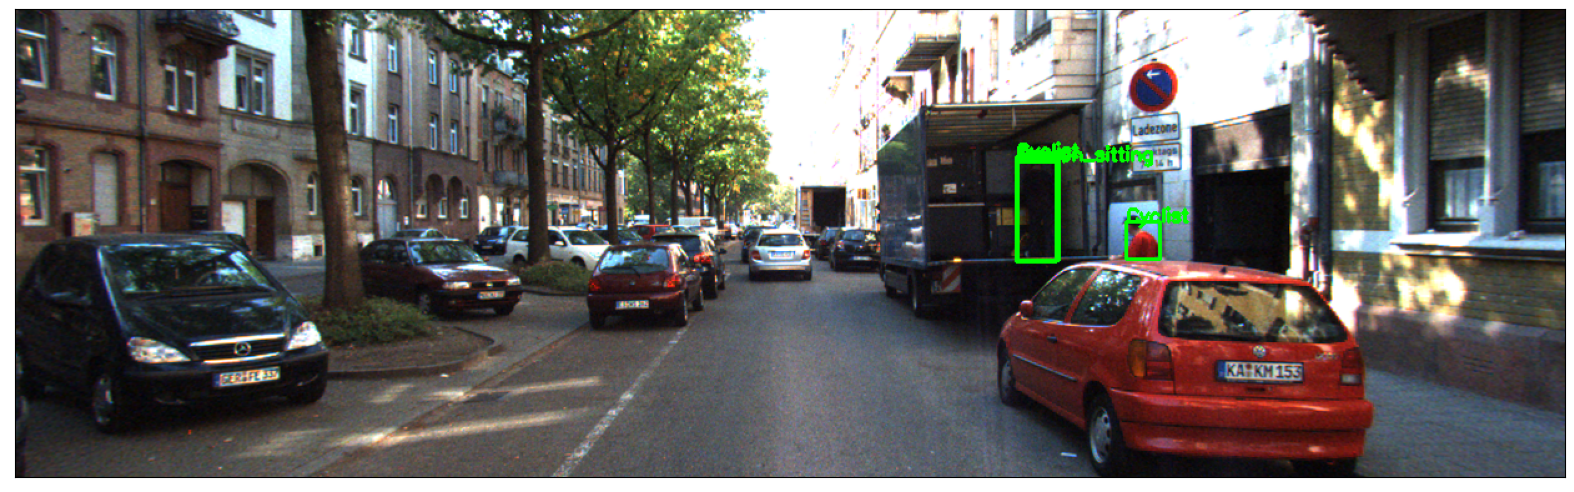

In [79]:
%matplotlib inline
import matplotlib.pyplot as plt 
from PIL import Image
import torchvision.transforms as T
import cv2

# https://haochen23.github.io/2020/04/object-detection-faster-rcnn.html#.Y0VLb8pBxJY

FasterRCNNtest = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = FasterRCNNtest.roi_heads.box_predictor.cls_score.in_features
FasterRCNNtest.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(
    in_features, num_classes=8)

torch.save(FasterRCNNtest.state_dict(), f"{'kitti-model'}/model-origin.pth")
FasterRCNNtest.load_state_dict(torch.load('./kitti-model/model60.pth'))

FasterRCNNtest.eval()

#FasterRCNN.eval()

CLASS_NAMES = ['Car', 'Truck', 'Cyclist', 'Tram', 'Person_sitting', 'Misc', 'Van', 'Pedestrian']


def get_prediction(img_path, confidence):
  """
    parameters:
      - img_path - path of the input image
      - confidence - threshold value for prediction score
  """
  img = Image.open(img_path)
  transform = T.Compose([T.ToTensor()])
  img = transform(img)
  pred = FasterRCNNtest([img]) # FasterRCNNtest
  
  print(pred)
  if pred[0]['scores'].detach().numpy().size == 0:
    return None, None
  pred_class = [CLASS_NAMES[i] for i in list(pred[0]['labels'].numpy())]
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
  pred_score = list(pred[0]['scores'].detach().numpy())
  #//print(pred_score)
  pred_index = []
  for x in pred_score:
    if x > confidence:
      #//print(pred_score.index(x))
      pred_index.append(pred_score.index(x))
      print(pred_index)
  if len(pred_index) == 1:
      print("Only One Object Detected.")
      return [pred_boxes[0]], [pred_class[0]] 
  if len(pred_index) == 0:
      print("No Object Detected.")
      return None, None
    
  pred_t = [pred_score.index(x) for x in pred_score if x>confidence][-1]
  pred_boxes = pred_boxes[:pred_t+1]
  pred_class = pred_class[:pred_t+1]
  return pred_boxes, pred_class


def detect_object(img_path, confidence=0.5, rect_th=2, text_size=0.5, text_th=2):
  """
    parameters:
      - img_path - path of the input image
      - confidence - threshold value for prediction score
      - rect_th - thickness of bounding box
      - text_size - size of the class label text
      - text_th - thichness of the text
  """
  boxes, pred_cls = get_prediction(img_path, confidence)
  if boxes == None and pred_cls == None:
    print("NO Detection")
    return None
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  
  for i in range(len(boxes)):
    aa, bb = boxes[i][0][0], boxes[i][0][1]
    a, b = boxes[i][1][0], boxes[i][1][1]
    cv2.rectangle(img, (int(aa), int(bb)), (int(a), int(b)), 
                  color=(0, 255, 0), thickness=rect_th)
    cv2.putText(img, pred_cls[i], (int(aa), int(bb)), cv2.FONT_HERSHEY_SIMPLEX,
                text_size, (0,255,0),thickness=text_th)
  
  plt.figure(figsize=(20,30))
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.show()

detect_object('./kitti-dataset/Kitti/raw/testing/image_2/000462.png', confidence=0.07)
detect_object('./kitti-dataset/Kitti/raw/testing/image_2/000423.png', confidence=0.07)